# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

Aim and Objectives:
* Transform and analyse raw, tabular daily_temp_tsdf from a statistics website.
* Apply multiple machine-learning techniques to this daily_temp_tsdf.
* Investigate and document ethical and social implications.
* Create a data project and analysis related to real-life statistics.
* Deadline: 10th January 2024

Deliverables:
* 20 Pages (Maximum) Document in the IEEE Access format
* Project GitHub Pages Webpage
* 10 Page (Maximum) Generative AI Usage Journal

**IMPORTANT**: For dependencies, running and committing this notebooks, see: [README](./README.md)

## Problem: Given the Climate and Population Trends, Can we forcecast Electricity Demands?

Model Outcomes:
* Energy Demand Forecasting
* Risk - Outages, Climate, etc?

# Data Preparation

## Dataset provenance
Electricity:
- [NSO Table 1. Electricity supply by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 2. Gross production of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 3. Electricity production from power plants by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 4. Estimated electricity production from renewable sources by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 5. Imports and exports of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 6. Electricity supply by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 8. GHG emissions from fuel combustion in power plants by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [Eurostat Net electricity generation by type of fuel - monthly data](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_pem__custom_8232363/default/table?lang=en)

Climate:
- [Meteostat Temperature](https://dev.meteostat.net/sources.html)

Population:
- [Population Worldbank](https://data.worldbank.org/country/malta)

Indutrial Indices:
- [NSO Index of Industrial Production November 2018](https://nso.gov.mt/wp-content/uploads/News2019_003.pdf)
- [NSO Index of Industrial Production December 2018](https://nso.gov.mt/wp-content/uploads/News2019_019.pdf)
- [NSO Index of Industrial Production May 2020](https://nso.gov.mt/wp-content/uploads/News2020_109.pdf)
- [NSO Index of Industrial Production December 2020](https://nso.gov.mt/wp-content/uploads/News2021_020.pdf)
- [NSO Short Term Industrial Indicators Q4 2018](https://nso.gov.mt/wp-content/uploads/News2019_033.pdf)
- [GDP](https://data.worldbank.org/indicator/NY.GDP.MKTP.KN?locations=MT&view=chart)

## Preparation

* **Manual** edit of CSV to delete text, disclaimers and images from NSO. Output is a clean table.
* Removal of **features with >20% NaNs**. Too many gaps to interpolate.
* Drop data **> 3 standard deviations**.
* Resample to 22years from **2000 to 2022**.
* Normalize and reduce data. E.g. Mega Watts to Giga Watts, Minutes to Days, etc.
* Linear **interpolation of NaNs**.

In [23]:
import os
import re

import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

# Constants here
START_DATE = datetime(2003, 1, 1)
END_DATE = datetime(2022, 12, 31)

# All unprocessed CVs should go here.
RAW_DATA_PATH = "./raw_data"

# Base electricity datasets
ELECTRIC_MW_DS = [
    "Max_Demand_MW.csv",
    "Plant_Production_MWh.csv",
    "Imports_MWh.csv",
    "Renewables_Production_MWh.csv",
]
MEGA_TO_GIGA = 1000

all_data_df = None  # Main Dataset DF.
for filename in ELECTRIC_MW_DS:
    file_path = os.path.join(RAW_DATA_PATH, filename)
    # Convert mega to giga
    value_col = filename.split(".")[0].replace("_MW", "_GW")
    print(f"Processing: {filename}")

    df = pd.read_csv(file_path)

    # We will melt month (y-index) and year (x-index) to
    # create an index for each feature timeseries
    melted_df = df.melt(id_vars=["Month"], var_name="Year", value_name=value_col)
    melted_df[value_col] = melted_df[value_col].apply(
        # Clean - Values from string to scalar. Drop non-numeric characters (e.g. ,)
        lambda x: float(re.sub("[^0-9.]", "", str(x))) / MEGA_TO_GIGA
        if isinstance(x, (str))
        else float(x / MEGA_TO_GIGA)
    )

    # set the index of Year-month, this will be for all timeseries
    melted_df["Date"] = pd.to_datetime(
        melted_df["Month"] + " " + melted_df["Year"], format="%B %Y"
    )
    melted_df.set_index("Date", inplace=True, drop=True)

    min_date = melted_df.index.min()
    max_date = melted_df.index.max()
    nan_count = melted_df[value_col].isnull().sum()
    skewness = round(skew(melted_df[value_col].dropna()), 2)
    kurt = round(kurtosis(melted_df[value_col].dropna()), 2)
    outliers_count = (
        melted_df[value_col]
        > melted_df[value_col].mean() + 3 * melted_df[value_col].std()
    ).sum()
    print(
        f"Stats => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
    )

    # Do we have long tails? Do we have extremes?
    melted_df[value_col] = melted_df[value_col].resample("MS").mean()
    melted_df[value_col] = round(melted_df[value_col], 2)  # drop long floating points
    melted_df = melted_df[
        (melted_df.index >= START_DATE) & (melted_df.index <= END_DATE)
    ]

    result_df = melted_df[value_col]
    if all_data_df is None:
        all_data_df = result_df
    else:
        all_data_df = pd.concat([all_data_df, result_df], axis=1, ignore_index=False)
        all_data_df = all_data_df.interpolate().fillna(0)

all_data_df.tail(3)

Processing: Max_Demand_MW.csv
Stats => min_date: 2003-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:1.55, skewness:1.09, outliers_count:4,  nan_count: 0
Processing: Plant_Production_MWh.csv
Stats => min_date: 2003-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:2.0, skewness:1.33, outliers_count:3,  nan_count: 0


Processing: Imports_MWh.csv
Stats => min_date: 2015-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:-0.77, skewness:0.31, outliers_count:0,  nan_count: 0
Processing: Renewables_Production_MWh.csv
Stats => min_date: 2013-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:-0.69, skewness:0.29, outliers_count:0,  nan_count: 60


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh
Date,,,,
2022-10-01,0.41,225.89,66.13,23.85
2022-11-01,0.41,206.40,13.05,16.79
2022-12-01,0.40,207.78,22.02,15.84


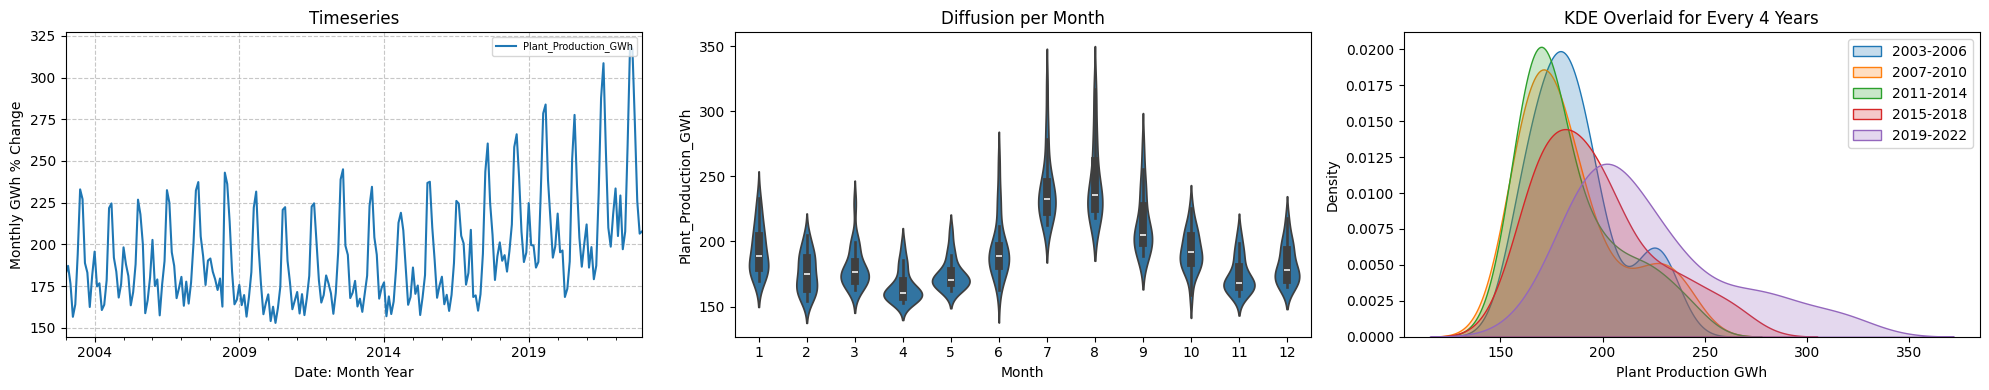

In [24]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Visually check if Plant_Production_GWh timeseries is healthy, its the most skewed.
all_data_df["Plant_Production_GWh"].plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Date: Month Year")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].grid(axis="both", linestyle="--", alpha=0.7)
axes[0].set_title("Timeseries")
axes[0].legend(fontsize=7, loc="upper right")

sampling_subset = pd.DataFrame(all_data_df["Plant_Production_GWh"].copy())
sampling_subset["Month"] = sampling_subset.index.month

# Distribution per Month will be used for weights for synthetic data
# for the rest, we observe skewness and outliers.
sns.violinplot(x="Month", y="Plant_Production_GWh", data=sampling_subset, ax=axes[1])
axes[1].set_title("Diffusion per Month")

axes[2].set_title("KDE Overlaid for Every 4 Years")
axes[2].set_xlabel("Plant Production GWh")
axes[2].set_ylabel("Density")
for start_year in range(all_data_df.index.year.min(), all_data_df.index.year.max(), 4):
    end_year = start_year + 3
    year_data = all_data_df[
        (all_data_df.index.year >= start_year) & (all_data_df.index.year <= end_year)
    ]
    sns.kdeplot(
        year_data["Plant_Production_GWh"],
        ax=axes[2],
        fill=True,
        label=f"{start_year}-{end_year}",
    )
axes[2].legend()

plt.tight_layout()
plt.show()

In [25]:
# the Datasets below need unique data cleaning
C02 = "PowerPlants_c02_KT.csv"

df = pd.read_csv(os.path.join(RAW_DATA_PATH, C02))
df["Year"] = pd.to_datetime(df["Year"], format="%Y")
df.set_index("Year", inplace=True, drop=True)
df = df.resample("MS").ffill()  # it misses Feb+

df.rename(columns={"CO2 kt": "powerplants_c02_kt"}, inplace=True)

# Create a copy of the subset and add columns for total and weights
sampling_subset = pd.DataFrame(all_data_df["Plant_Production_GWh"].copy())
sampling_subset = sampling_subset.resample("MS").ffill()

sampling_subset["total"] = sampling_subset.groupby(sampling_subset.index.year)[
    "Plant_Production_GWh"
].transform("sum")
sampling_subset["weights"] = (
    sampling_subset["Plant_Production_GWh"] / sampling_subset["total"]
)

df["powerplants_c02_kt"] = sampling_subset["weights"] * df["powerplants_c02_kt"]
df["powerplants_c02_kt"] = round(df["powerplants_c02_kt"], 2)
df = df[(df.index >= START_DATE) & (df.index <= END_DATE)]

all_data_df = pd.concat(
    [all_data_df, df["powerplants_c02_kt"]], axis=1, ignore_index=False
)

all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt
2022-10-01,0.41,225.89,66.13,23.85,62.49
2022-11-01,0.41,206.40,13.05,16.79,57.10
2022-12-01,0.40,207.78,22.02,15.84,57.48


In [26]:
GDP_DS = "gdp_EUR.csv"
UNIT_TO_BILLIONS = 1000000000

gdp_df = pd.read_csv(f"{RAW_DATA_PATH}/{GDP_DS}")
gdp_df = gdp_df.T
gdp_df.columns = ["GDP_bln"]
gdp_df["GDP_bln"] = gdp_df["GDP_bln"].apply(
    lambda x: round(
        float(re.sub("[^0-9.]", "", str(x))) / UNIT_TO_BILLIONS
        if isinstance(x, (str))
        else float(x / UNIT_TO_BILLIONS),
        2,
    )
)

# Indexed on year only, resample to monthly. interpolate everything.
gdp_df.index = pd.to_datetime(gdp_df.index, format="%Y")
gdp_df = gdp_df.resample("MS").mean()
gdp_df = gdp_df[(gdp_df.index >= START_DATE) & (gdp_df.index <= END_DATE)]

all_data_df = pd.concat([all_data_df, gdp_df], axis=1, ignore_index=False)
all_data_df["GDP_bln"] = (
    # We cannot have 1/2 a person!
    all_data_df["GDP_bln"]
    .interpolate()
    .ffill()
    .bfill()
)

all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln
2022-10-01,0.41,225.89,66.13,23.85,62.49,16.87
2022-11-01,0.41,206.40,13.05,16.79,57.10,16.87
2022-12-01,0.40,207.78,22.02,15.84,57.48,16.87


In [27]:
POP_DS = "malta_population.csv"
UNIT_TO_THOUSAND = 1000

pop_df = pd.read_csv(f"{RAW_DATA_PATH}/{POP_DS}")
pop_df = pop_df.T
pop_df.columns = ["Population_k"]
pop_df["Population_k"] = pop_df["Population_k"] / UNIT_TO_THOUSAND

# Indexed on year only, resample to monthly. interpolate everything.
pop_df.index = pd.to_datetime(pop_df.index, format="%Y")
pop_df = pop_df.resample("M").mean()
pop_df = pop_df[(pop_df.index >= START_DATE) & (pop_df.index <= END_DATE)]

# resample puts it on the last day of the month!
pop_df.index = pop_df.index.to_period("M").to_timestamp("M") + pd.DateOffset(days=1)

# Population is missing the last months from the resample.
all_data_df = pd.concat([all_data_df, pop_df], axis=1, ignore_index=False)
all_data_df["Population_k"] = (
    # We cannot have 1/2 a person!
    all_data_df["Population_k"]
    .interpolate()
    .ffill()
    .bfill()
)

all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k
2022-10-01,0.41,225.89,66.13,23.85,62.49,16.87,523.417
2022-11-01,0.41,206.40,13.05,16.79,57.10,16.87,523.417
2022-12-01,0.40,207.78,22.02,15.84,57.48,16.87,523.417


In [28]:
from meteostat import Point, Monthly

# Create Point for Malta - specify latitude and longitude
malta = Point(35.8992, 14.5141)
temp_data_df = Monthly(malta, START_DATE, END_DATE)
temp_data_df = temp_data_df.fetch()
temp_data_df = temp_data_df[
    (temp_data_df.index >= START_DATE) & (temp_data_df.index <= END_DATE)
]

temp_data_df.index = pd.to_datetime(temp_data_df.index, format="%Y-%m-%d")
temp_data_df = temp_data_df.interpolate().bfill()
temp_data_df.head(3)

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2003-01-01,13.2,10.9,15.6,152.0,12.5,1014.9,9900.0
2003-02-01,10.4,7.9,13.0,150.0,12.5,1016.7,8280.0
2003-03-01,12.7,9.8,15.7,55.0,12.5,1020.6,13920.0


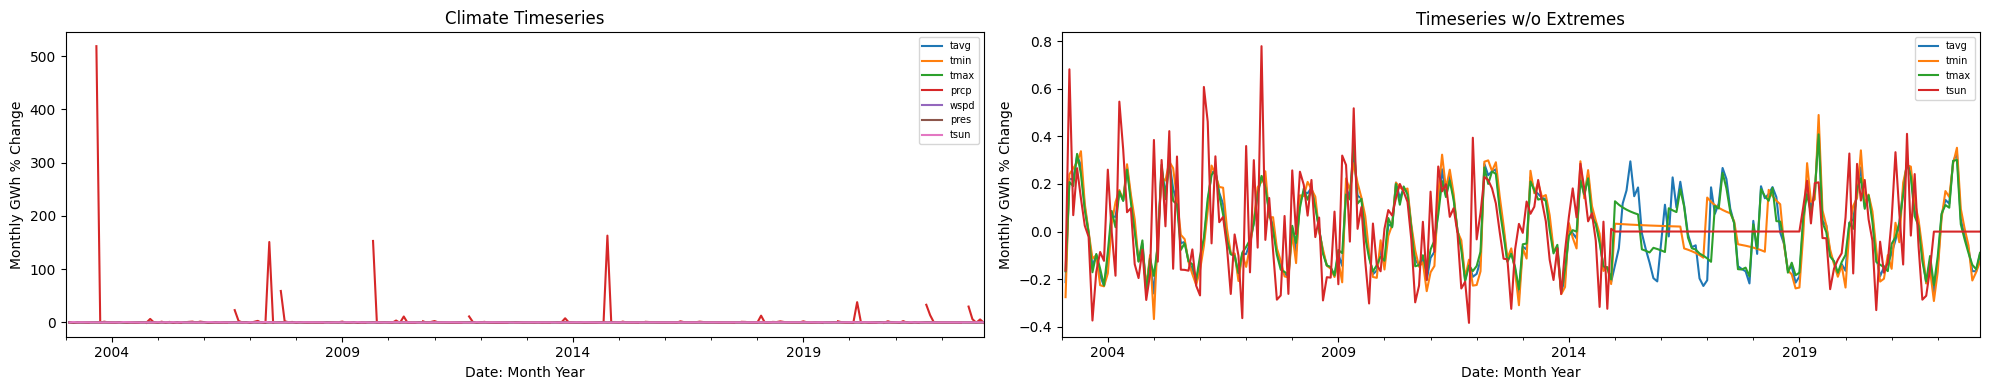

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Visually check if climate timeseries is healthy.
temp_data_df.pct_change().ffill().plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Date: Month Year")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].set_title("Climate Timeseries")
axes[0].legend(fontsize=7, loc="upper right")

temp_data_df.drop(columns=["prcp", "wspd", "pres"], axis=1).pct_change().ffill().plot(
    kind="line", ax=axes[1]
)
axes[1].set_xlabel("Date: Month Year")
axes[1].set_ylabel("Monthly GWh % Change")
axes[1].set_title("Timeseries w/o Extremes")
axes[1].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

In [30]:
all_data_df = pd.concat(
    [all_data_df, temp_data_df[["tmin", "tavg", "tmax"]]], axis=1, ignore_index=False
)

all_data_df = all_data_df.interpolate().ffill().fillna(0)
all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k,tmin,tavg,tmax
2022-10-01,0.41,225.89,66.13,23.85,62.49,16.87,523.417,18.2,21.6,25.3
2022-11-01,0.41,206.40,13.05,16.79,57.10,16.87,523.417,15.1,18.0,21.3
2022-12-01,0.40,207.78,22.02,15.84,57.48,16.87,523.417,13.2,16.3,19.4


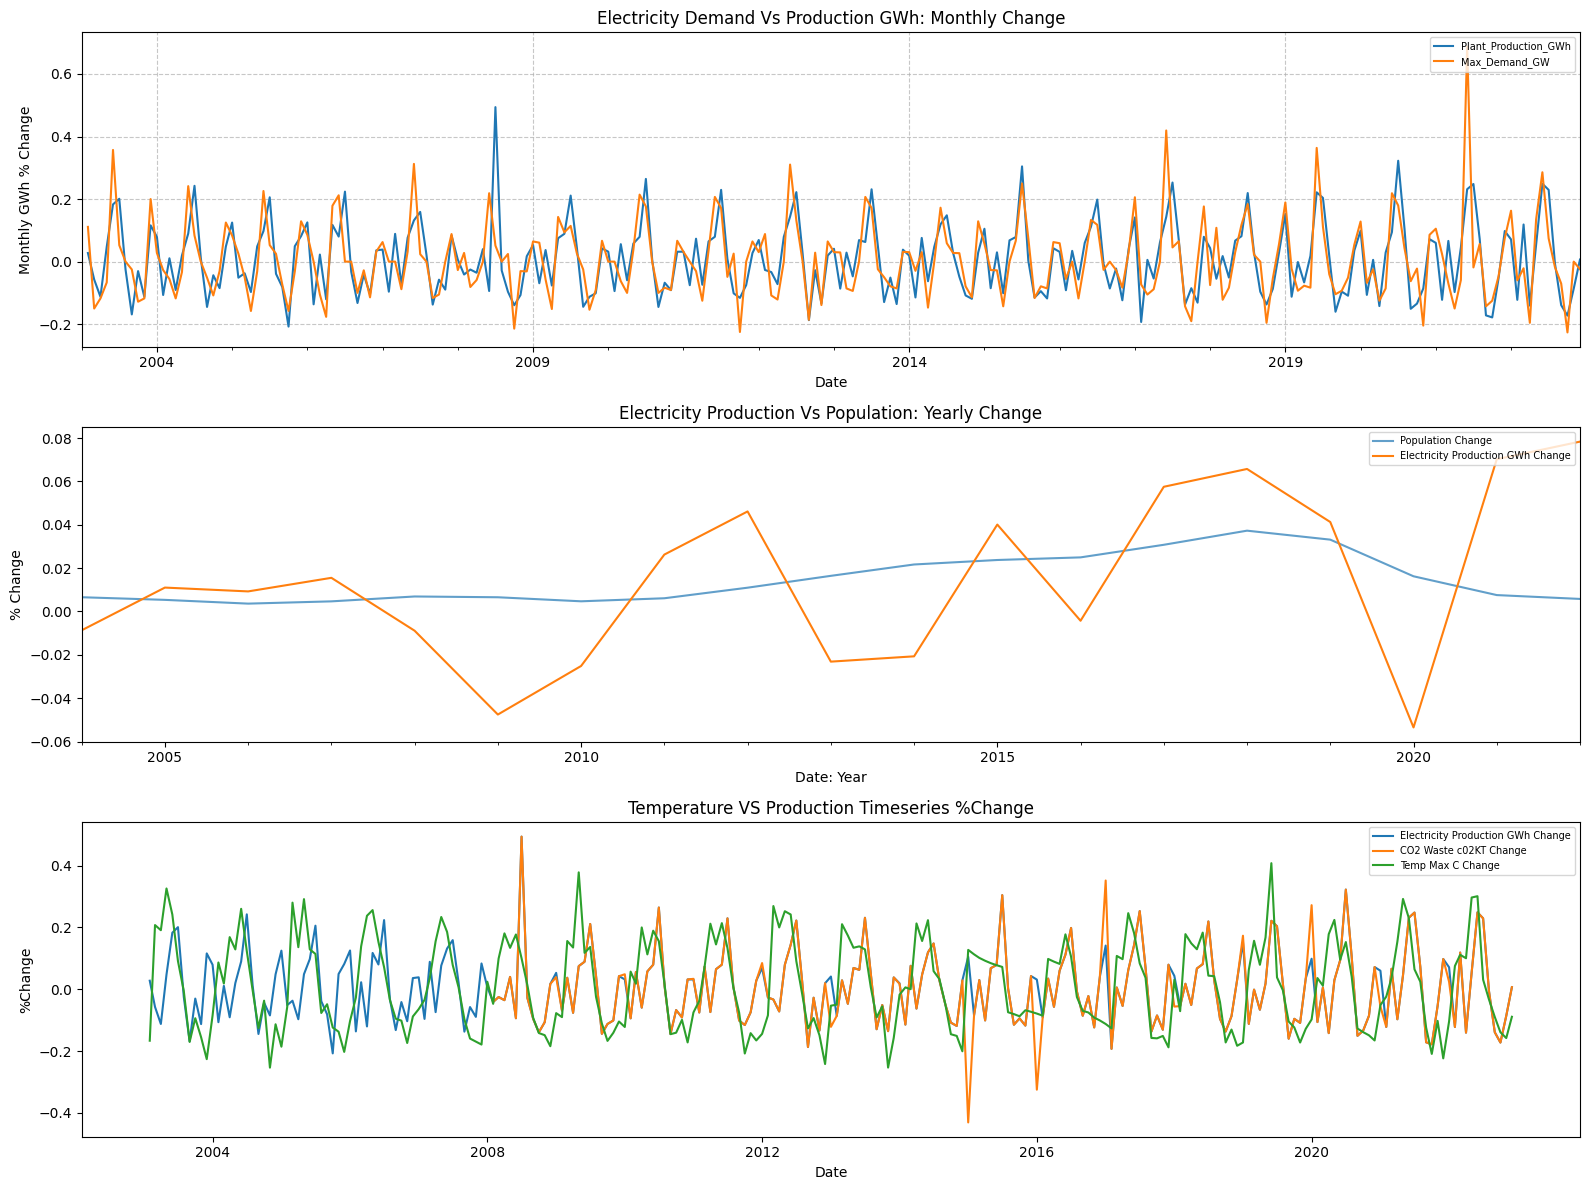

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
all_data_df[["Plant_Production_GWh", "Max_Demand_GW"]].pct_change().ffill().plot(
    kind="line", ax=axes[0]
)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].grid(axis="both", linestyle="--", alpha=0.7)
axes[0].set_title("Electricity Demand Vs Production GWh: Monthly Change")
axes[0].legend(fontsize=7, loc="upper right")

all_data_df["Population_k"].resample("YS").mean().pct_change().dropna().plot(
    kind="line", ax=axes[1], alpha=0.7, label="Population Change"
)
all_data_df["Plant_Production_GWh"].resample("YS").mean().pct_change().dropna().plot(
    kind="line", ax=axes[1], label="Electricity Production GWh Change"
)
axes[1].set_xlabel("Date: Year")
axes[1].set_ylabel("% Change")
axes[1].set_title("Electricity Production Vs Population: Yearly Change")
axes[1].legend(fontsize=7, loc="upper right")

axes[2].plot(
    all_data_df["Plant_Production_GWh"].pct_change().dropna(),
    label="Electricity Production GWh Change",
)
axes[2].plot(
    all_data_df["powerplants_c02_kt"].pct_change().dropna(),
    label="CO2 Waste c02KT Change",
)
axes[2].plot(all_data_df["tmax"].pct_change().dropna(), label="Temp Max C Change")
axes[2].set_ylabel("%Change")
axes[2].set_xlabel("Date")
axes[2].set_title("Temperature VS Production Timeseries %Change")
axes[2].legend(fontsize=7, loc="upper right")


plt.tight_layout()
plt.show()

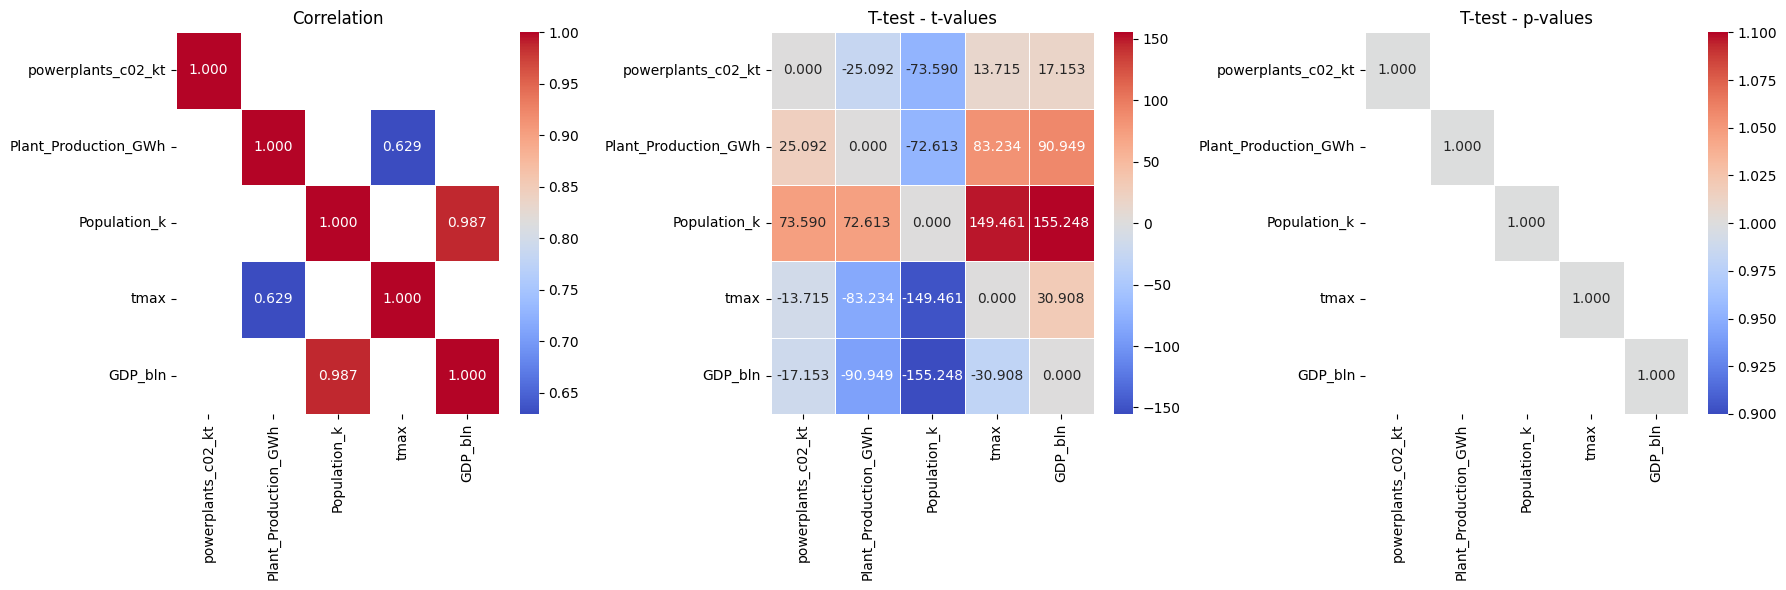

In [32]:
from scipy.stats import ttest_ind

CR_THRESHOLD = 0.6
P_THRESHOLD = 0.05
features = [
    "powerplants_c02_kt",
    "Plant_Production_GWh",
    "Population_k",
    "tmax",
    "GDP_bln",
]

corr_matrix = all_data_df[features].corr()
t_value_matrix = np.zeros((len(features), len(features)))
p_value_matrix = np.zeros((len(features), len(features)))

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        t_value_matrix[i, j], p_value_matrix[i, j] = ttest_ind(
            all_data_df[feature1], all_data_df[feature2], equal_var=False
        )

t_value_df = pd.DataFrame(t_value_matrix, index=features, columns=features)
p_value_df = pd.DataFrame(p_value_matrix, index=features, columns=features)

# Plot heatmaps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(np.abs(corr_matrix) <= CR_THRESHOLD),
)
plt.title("Correlation")

plt.subplot(1, 3, 2)
sns.heatmap(t_value_df, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("T-test - t-values")

plt.subplot(1, 3, 3)
sns.heatmap(
    p_value_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(p_value_df <= P_THRESHOLD),
)
# Need to see if there is actual stats significance in the data changes.
plt.title("T-test - p-values")

plt.tight_layout()
plt.show()

In [33]:
# this is a time series. No randm sampling for splits.
all_data_df.sort_index(inplace=True)
all_data_df.index.name = "Date"

TRAIN_PERC = 0.7
TEST_PERC = 0.15  # we validate the rest
train_size = int(len(all_data_df) * TRAIN_PERC)
test_size = int(len(all_data_df) * TEST_PERC)

train_df = all_data_df.iloc[:train_size]
test_df = all_data_df.iloc[train_size : train_size + test_size]
validate_df = all_data_df.iloc[train_size + test_size :]

train_df.to_csv("./data/train_data.csv", index=True)
test_df.to_csv("./data/test_data.csv", index=True)
validate_df.to_csv("./data/validate_data.csv", index=True)